## Cleaning

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn import metrics, preprocessing
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder

Read in player data

In [2]:
playerDf = pd.read_csv('data/CollegeBasketballPlayers2009-2021.csv', low_memory=False)

#initial dropping of inconsistant data for player data 
playerDf = playerDf.rename(columns = {'Unnamed: 64' : 'role_position'})
playerDf = playerDf.drop('Unnamed: 65', axis=1) # Has no meaning in the dataset
playerDf = playerDf.drop('ht', axis=1) # Temporarily excluding this column due to inconsistent date formats and other values
playerDf = playerDf.drop('num', axis=1) # It might denote a player's choice or position but with significant variation in meaning.
playerDf = playerDf.drop('type', axis=1) # Column has 1 unique value
playerDf= playerDf.drop('pid', axis=1) # catigorical, not needed 
playerDf= playerDf.drop('yr', axis=1) # catigorical, not needed 

playerDf.shape

(61061, 60)

Display columns with over 60% nulls and drop them

In [3]:
# Count and remove columns with over 60% nan values from players
total = len(playerDf)
for column in playerDf.columns:
    count = playerDf[column].isna().sum()
    percent= (count/ total) * 100
    if (percent>=60):
        print(f"Player  DF: Column '{column}':", f"Number of NaN: {count}", f"Percentage: {percent:.2f}%")

Player  DF: Column 'Rec Rank': Number of NaN: 42591 Percentage: 69.75%
Player  DF: Column 'pick': Number of NaN: 59626 Percentage: 97.65%


In [4]:
#Drop all the over 60% cols from the player. Dont drop pick, nan recorded as not drafted, need for predictions filling in later
playerDf = playerDf.drop('Rec Rank', axis=1) 

In [5]:
player_corr_matrix = playerDf.corr()

# Create a heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(player_corr_matrix, fmt=".2f", linewidths=.5)
# plt.title('Correlation Matrix Heatmap')
# plt.show()

Findand remove redundant data 

In [6]:
correlation_threshold = 0.9

# Create positive correlation matrix
corr_df = playerDf.corr().abs()


# Create and apply mask
mask = np.triu(np.ones_like(corr_df, dtype=bool))
tri_df = corr_df.mask(mask)

# Find columns that meet threshold
features_to_drop = [c for c in tri_df.columns if any(tri_df[c] > 0.90)]
print(features_to_drop)

['Min_per', 'Ortg', 'eFG', 'FTM', 'twoPM', 'twoPA', 'TPM', 'rimmade', 'midmade', 'dunksmade', 'drtg', 'dporpag', 'stops', 'gbpm', 'mp', 'dreb']


In [7]:
# Remove the highly correlated features from the DataFrame
playerDf = playerDf.drop(columns=features_to_drop, axis=1)

# Display the new shape of the DataFrame
print("Shape of the DataFrame after removing highly correlated features:", playerDf.shape)

Shape of the DataFrame after removing highly correlated features: (61061, 43)


In [8]:
player_corr_matrix = playerDf.corr()

# # Create a heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(player_corr_matrix, fmt=".2f", linewidths=.5)
# plt.title('Correlation Matrix Heatmap')
# plt.show()

KNN to fill in all NAN values

In [9]:
#if drafted, change to 1 
playerDf.loc[playerDf["pick"] > 0, "pick"] = 1
#not drafted was nan, replace with 0 
playerDf.loc[playerDf["pick"] != 1, "pick"] = 0

In [10]:
team_label_encoder = LabelEncoder()
playerDf['team'] = team_label_encoder.fit_transform(playerDf['team'])

conf_label_encoder = LabelEncoder()
playerDf['conf'] = conf_label_encoder.fit_transform(playerDf['conf'])

role_position_label_encoder = LabelEncoder()
playerDf['role_position'] = role_position_label_encoder.fit_transform(playerDf['role_position'])

player_name_label_encoder = LabelEncoder()
playerDf['player_name'] = player_name_label_encoder.fit_transform(playerDf['player_name'])

In [11]:
imputer = KNNImputer(n_neighbors=10)
imputed_numeric = imputer.fit_transform(playerDf.select_dtypes(include=np.number))
dfBasketballTraining_filled = pd.DataFrame(imputed_numeric, columns=playerDf.select_dtypes(include=np.number).columns)
string_columns = playerDf.select_dtypes(include='object').columns
imputed_data = pd.concat([playerDf[string_columns], dfBasketballTraining_filled], axis=1)

In [12]:
playerDf = pd.DataFrame(imputed_data, columns=playerDf.columns)

Split into training and test 

Remove overlapping players based on 4 year college career so that the training set is all "new" players

In [13]:
trainDf=playerDf.loc[playerDf['year'] <2017]
testDf= playerDf.loc[playerDf['year'] >= 2021]

Feature selection 

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

X = trainDf.drop("pick", axis=1)
y = trainDf["pick"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fit a RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100)
rf_classifier.fit(X_train, y_train)

#importance
sel = SelectFromModel(rf_classifier)
sel.fit(X_train, y_train)

# Get support and selected feature names
selected_feature_indices = sel.get_support()
selected_features = X_train.columns[selected_feature_indices]

print("Selected features:")
print(selected_features)

print("Feature importance scores:")
print(sel.estimator_.feature_importances_)


Selected features:
Index(['GP', 'porpag', 'adjoe', 'midmade+midmiss', 'dunksmiss+dunksmade',
       'adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm', 'pts'],
      dtype='object')
Feature importance scores:
[0.02039485 0.01829425 0.01442592 0.03638108 0.01827179 0.01945648
 0.01751129 0.01710401 0.01703608 0.01902283 0.02342134 0.01802754
 0.01754516 0.01808062 0.01476111 0.01933162 0.01337715 0.01716381
 0.05186927 0.03572914 0.01718497 0.00932807 0.01895678 0.02255237
 0.03543482 0.01896023 0.0183368  0.03486189 0.01363306 0.05845716
 0.05629986 0.03163075 0.02907873 0.0403973  0.02879984 0.01969412
 0.02300277 0.01923612 0.01773062 0.02299153 0.02817362 0.00805325]


In [27]:
trainDf.loc[trainDf['player_name']==1314.0 ]

,player_name,team,conf,GP,usg,TS_per,ORB_per,DRB_per,AST_per,TO_per,...,dbpm,ogbpm,dgbpm,oreb,treb,ast,stl,blk,pts,role_position
4,1314.0,230.0,10.0,33.0,22.0,54.31,8.3,18.6,8.2,22.7,...,0.109983,-1.684860,-0.668318,1.4242,4.7273,0.8485,0.4545,0.3333,7.5758,8.0
685,1314.0,225.0,6.0,33.0,10.7,53.23,7.4,10.2,3.4,16.8,...,2.076820,-1.031820,1.490050,0.8485,2.0606,0.2727,0.2727,0.3939,2.3939,8.0
8409,1314.0,344.0,24.0,4.0,8.7,0.00,20.1,20.1,0.0,0.0,...,-6.670430,-3.675910,-5.352120,0.2500,0.5000,0.0000,0.0000,0.0000,0.0000,2.0
12523,1314.0,285.0,24.0,30.0,18.7,53.90,5.1,11.3,7.0,14.4,...,0.348772,2.725180,0.490090,1.0333,3.2333,0.7667,0.5333,0.2333,8.7000,6.0
15649,1314.0,285.0,25.0,37.0,18.8,49.47,4.2,15.5,8.5,17.3,...,1.698680,0.576665,1.461380,0.8649,4.0270,1.0270,0.6216,0.1081,8.0811,7.0
19376,1314.0,285.0,25.0,4.0,17.0,28.64,1.6,13.3,2.6,24.7,...,-0.184311,-6.919020,-0.210866,0.2500,2.2500,0.2500,0.2500,0.2500,3.0000,6.0
23376,1314.0,285.0,25.0,36.0,18.5,61.00,3.3,13.9,12.4,18.5,...,1.458420,2.716590,1.409900,0.9167,5.0000,2.0833,0.8611,0.1111,12.3056,7.0
27789,1314.0,285.0,25.0,37.0,21.2,57.30,3.8,18.8,15.2,15.7,...,1.418250,5.257200,1.035880,1.1351,6.9189,2.5405,0.7568,0.1892,14.7838,7.0
36508,1314.0,109.0,14.0,27.0,12.7,49.88,1.7,10.9,9.1,22.8,...,-1.334410,-3.841620,-0.478065,0.1852,1.2593,0.6296,0.4074,0.0000,2.3333,7.0


## Model

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score

In [47]:
#Trying with k-fold cross validation 

In [48]:
def get_training_data(data, start, stop, end=False):
    if end==False: 
        subset = data.iloc[start:stop]
    else: #include the raminder of the samples in the last set 
        subset = data.iloc[start:]
    return subset
    

In [49]:
#get divided training data for k-crossfold validation 
#all features (no pick)
# features=['usg', 'DRB_per', 'AST_per', 'TO_per',  'twoP_per', 'blk_per', 'porpag','bpm', 'dbpm', 'ogbpm', 'dgbpm']
# features = ['GP', 'FTA', 'porpag', 'adjoe', 'adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm','blk', 'pts']
# features = ['GP', 'FTA', 'porpag', 'adjoe', 'adrtg', 'bpm', 'obpm', 'dbpm', 'blk', 'pts']
features=['porpag', 'adjoe','adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm', 'pts']

# features= selected_features

numFeatures= len(features)
rows=trainDf.shape[0]
numSets=5
perSet = int(rows/numSets)

#shuffle
trainDf = trainDf.sample(frac=1, random_state=42).reset_index(drop=True)

set1=get_training_data(trainDf, 0,perSet) 
set2=get_training_data(trainDf, perSet, perSet*2) 
set3=get_training_data(trainDf, perSet*2, perSet*3) 
set4=get_training_data(trainDf, perSet*3, perSet*4) 
set5=get_training_data(trainDf, perSet*4, 0, True) #set will inclide any extera entries 
trainingSets=[set1, set2, set3, set4, set5]

In [50]:
def kFoldTrain(model, sets, features, target='pick'):
    prefMetrics = {'Precision': [], 'Recall': [], 'F1 Score': []}

    for j in range(len(sets)):
        valSet=sets[j]
        
        for i in range(len(sets)):
            #dont train validation set against validation set 
            if i!=j: 
            
                #remove target variable pick from the training and the testing data 
                trainSet=sets[i]
                trainNoTarget=trainSet[features]
                trainTarget=trainSet[target]
                valNoTarget=valSet[features]
                valTarget=valSet[target]
                
                #train 
                model.fit(trainNoTarget, trainTarget)
                
                predVals = model.predict(valNoTarget)
                
                prefMetrics['Precision'].append(precision_score(valTarget, predVals))
                prefMetrics['Recall'].append(recall_score(valTarget, predVals))
                prefMetrics['F1 Score'].append(f1_score(valTarget, predVals))
            
    return prefMetrics 
                

In [51]:
#citations: 
#video: https://aleksandarhaber.com/ensemble-learning-in-scikit-learn-voting-classifiers/
#Documentation: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingClassifier.html
#build model 

#the 3 models for the ensemble 
logreg = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42)
randFor = RandomForestClassifier(n_estimators=50, random_state=15)
svm = SVC(probability=True, random_state=1) 

# voting ensemble classifier 
model = VotingClassifier(estimators=[('lr', logreg), ('rf', randFor), ('svm', svm)], voting='hard')

trainMetrics=kFoldTrain(model, trainingSets, features)

In [52]:
pd.DataFrame(trainMetrics)


,Precision,Recall,F1 Score
0,0.722222,0.062802,0.115556
1,0.705882,0.115942,0.199170
2,0.703704,0.091787,0.162393
3,0.581395,0.120773,0.200000
4,0.833333,0.143678,0.245098
5,0.666667,0.160920,0.259259
6,0.703704,0.109195,0.189055
7,0.736842,0.160920,0.264151
8,0.851852,0.111650,0.197425
9,0.750000,0.087379,0.156522


In [53]:
#test the model 
testNoPick=testDf[features]
testPick=testDf['pick']

# Predict if player was selected for the draft on the test set
predTest = model.predict(testNoPick)


Validation/testing precision, recall and fscore 

In [54]:
# #preformance metrics for validation 
# precision = precision_score(valPick, predVals)
# recall = recall_score(valPick, predVals)
# f1 = f1_score(valPick, predVals)

# print('Precision on Validation Set:', precision)
# print('Recall on Validation Set:', recall)
# print('F1-score on Validation Set:', f1)

#preformance metrics for test 
print()
tPrecision = precision_score(testPick, predTest)
tRecall = recall_score(testPick, predTest)
tF1 = f1_score(testPick, predTest)

print('Precision on Test Set:', tPrecision)
print('Recall on Test Set:', tRecall)
print('F1-score on Test Set:', tF1)



Precision on Test Set: 0.47058823529411764
Recall on Test Set: 0.16326530612244897
F1-score on Test Set: 0.24242424242424243


## Test run pref values for cross fold and various features selected:

1) features = ['GP', 'FTA', 'porpag', 'adjoe', 'adrtg', 'bpm', 'obpm', 'dbpm', 'blk', 'pts']

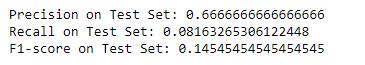

2) features=['usg', 'DRB_per', 'AST_per', 'TO_per',  'twoP_per', 'blk_per', 'porpag','bpm', 'dbpm', 'ogbpm', 'dgbpm']

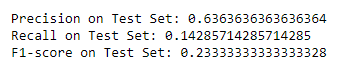

3) features=['porpag', 'adjoe','adrtg', 'bpm', 'obpm', 'dbpm', 'ogbpm', 'dgbpm', 'pts']
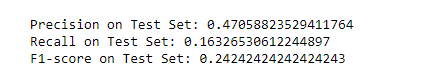

# Testing by training on balanced data

In [61]:
def get_training_data(dataframe, replacement, features = 13, multiplicity = 10):
    trainingCount = int(features*multiplicity/2)
    not_drafted = dataframe[dataframe['pick'].isnull()].sample(n=trainingCount, replace=replacement)
    drafted = dataframe[dataframe['pick'].notnull()].sample(n=trainingCount, replace=replacement)
    return pd.concat([not_drafted, drafted], ignore_index=True)

In [62]:
def trainRandSets(model, features, sets, target='pick'): 
    prefMetrics = {'Precision': [], 'Recall': [], 'F1 Score': []}

    for data in sets:
        X = data.drop(target, axis=1) 
        y = data[target] 
        trainTarget, valTarget, trainNoTarget, valNoTarget= train_test_split(X, y, test_size=0.2, random_state=42)

        #train 
        model.fit(trainNoTarget, trainTarget)

        predVals = model.predict(valNoTarget)

        prefMetrics['Precision'].append(precision_score(valTarget, predVals))
        prefMetrics['Recall'].append(recall_score(valTarget, predVals))
        prefMetrics['F1 Score'].append(f1_score(valTarget, predVals))
        
    return prefMetrics 

In [63]:
def shuffle(): 
    trainDf = trainDf.sample(frac=1, random_state=42).reset_index(drop=True)

set1=get_training_data(trainDf, False, len(features))
shuffle()
set2=get_training_data(trainDf, False, len(features))
shuffle()
set3=get_training_data(trainDf, False, len(features))
shuffle()
set4=get_training_data(trainDf, False, len(features))
shuffle()
set5=get_training_data(trainDf, False, len(features))

trainingSets[set1, set2, set3, set4, set5]

ValueError: a must be greater than 0 unless no samples are taken

In [ ]:
logreg = LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42)
randFor = RandomForestClassifier(n_estimators=50, random_state=15)
svm = SVC(probability=True, random_state=1) 

# voting ensemble classifier 
model2 = VotingClassifier(estimators=[('lr', logreg), ('rf', randFor), ('svm', svm)], voting='hard')

#recycle the kfold train method since it's still just testing all the data 
trainMetrics=trainTandSets(model2,features, trainingSets)
